<a id="title_ID"></a>
# Intermediate: Overlay a Cutout of the TESS FFIs with DSS imaging

This notebook shows the user how to use the MAST programmatic interface to create a cutout of the small section of the TESS FFIs. For this example we will determine the RA and Dec for TIC 261105201. We then perform a query to determine which sectors contain this RA and Dec, peform a cutout of the FFI time series, open the resulting target pixel files, and plot the first image of each file with the WCS overlayed on the image. Finally we will create a light curve from the resulting image by creating a photometric aperture and summing the light in our pixels.  

This tutorial shows the users how to do the following: use `astroquery.catalogs` to query the TIC, use astroquery Tesscut to determine the number of sectors that contain our target and download a FFI cutout.


### Table of Contents 
[Get Tesscut with Astroquery](#get_tesscut) <br>
   
- [Download Tesscut](#download_tess)<br>
- [Make Kepler TPF](#make_tpf)<br>
- [Make GIF](#make_gif)<br> 
- [Find TIC objects](#find_tic)<br>
- [Overlay TessCut and TIC](#plot_tpf_tic)<br>

[Get DSS image](#get_dss) <br>
[Overlay Tesscut and DSS](#overlay_images) <br>
[Additional Resources](#resources) <br>
[About this Notebook](#about_ID) 


## TESSCut Overlay with DSS
This notebook is an example of accessing and displaying a TESS FFI Cutout using the MAST TessCut service built into astroquery.  It uses astroquery to retrieve the related objects from the Tess Input Catalog (TIC). We then grab the related DSS image and overlay the TIC objects and the TESSCut image altogether.   

## Import Statements
<a id="imports_ID"></a>

We start with a few import statements.
- *os* to handle path and file operations
- *requests* to handle HTTP get requests
- *numpy* to handle array functions
- *matplotlib.pyplot* for plotting the data
- *k2flix* to load and create a Target Pixel File object and make GIFs 
- *astroquery.mast* for the Catalogs and for Tesscut.
- *astropy.units* for using proper astronomy units
- *astropy.io fits* for accessing FITS files
- *astropy.wcs WCS* to interpret the World Coordinate Systems
- *astropy.coordinates SkyCoord* for creating an on-sky coordinate
- *astropy.visualizaton simple_norm* for normalizing data for plots
- *reproject reproject_interp* for reprojecting images from one WCS coordinate system into another
- *IPython.display Image* for loading a GIF image in the notebook
- *ipywidgets* to create an interactive plot with widget slider 

In [1]:
# import the packages we need
import os
import numpy as np
import requests
import k2flix
%matplotlib inline
import matplotlib.pyplot as plt

# astroquery
from astroquery.mast import Tesscut
from astroquery.mast import Catalogs

# Astropy
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm

from reproject import reproject_interp

from IPython.display import Image
from ipywidgets import interact, interactive, fixed, interact_manual

<a id="get_tesscut"></a>
## Getting a Custom TESS Cutout Target Pixel File
The first step is to get the Target Pixel File.  We can download a custom target pixel file using the **Astroquery** python package. In particular we will use the ``download_tesscut`` method from the [Tesscut](https://astroquery.readthedocs.io/en/latest/mast/mast.html#tesscut) module.  Let's create a Tess cutout centered on RA, Dec = 66.582618, -67.806508 in a 11x11 pixel window.    


In [2]:
# select a target and cutout size in pixels
ra, dec = 66.582618, -67.806508
target = '{0}, {1}'.format(ra, dec)
x = y = 11

# set local file path to current working directory
path = os.path.abspath(os.path.curdir)

<a id="download_tesscut"></a>
### Use Astroquery to retrieve the TESSCut image
The `download_cutouts` method requires as input an Astropy SkyCoord object, a cutout size in pixels and optionally accepts a download path. This will download the custom cutout into the specified path and returns and Astropy table object with the paths to all the downloaded files.   

We are limiting this cutout to sector 27 so that this Notebook runs quickly; if you do not specify a sector, all matching targets will be returned.

In [3]:
# create a sky coordinate object
cutout_coords = SkyCoord(ra, dec, unit="deg")
    
# download the files and get the list of local paths
try:
    table = Tesscut.download_cutouts(coordinates=cutout_coords, sector=27, size=x, path=path)
except Exception as e:
    print('Error: Could not download cutouts: {0}'.format(e))
else:
    print(table)
    files = table['Local Path']

 [Done]


                                                                    Local Path                                                                   
-------------------------------------------------------------------------------------------------------------------------------------------------
/home/runner/work/mast_notebooks/mast_notebooks/notebooks/TESS/interm_tesscut_dss_overlay/tess-s0027-4-1_66.582618_-67.806508_11x11_astrocut.fits


<a id="make_tpf"></a>
### Open a Target Pixel File 
We'll be using Kepler's [k2flix](https://barentsen.github.io/k2flix/) Python package to open and access the file, using the ``TargetPixelFile`` class.  This is a convenience class that allows use to easily create a GIF.  Kepler provides a range of [software tools](https://keplerscience.arc.nasa.gov/software.html) that should also work with TESS data. We instantiate a new object and print some basic information about the custom TPF.  We need the WCS of the new TESS cutout, so we use Astropy WCS to define and create the wcs using the APERTURE extension of the cutout file.

In [4]:
# grab the first file in the list
filename = files[0]

# create the TargetPixelFile instance
tpf = k2flix.TargetPixelFile(filename)

# get number of pixels in flux array 
n_pix = tpf.flux().shape[0]

# compute field of view in degrees
res = 21.0 * (u.arcsec/u.pixel)
area = res * (n_pix * u.pixel)
d = area.to(u.degree)
fov = d.value 

# compute the wcs of the image
wcs = WCS(tpf.hdulist['APERTURE'].header)

# print some info
print('filename', tpf.filename)
print('Target TPF', target)
print('Field of View [degrees]', fov)
print('Number pixels', tpf.flux().shape)

filename /home/runner/work/mast_notebooks/mast_notebooks/notebooks/TESS/interm_tesscut_dss_overlay/tess-s0027-4-1_66.582618_-67.806508_11x11_astrocut.fits
Target TPF 66.582618, -67.806508
Field of View [degrees] 0.06416666666666666
Number pixels (11, 11)


<a id="make_gif"></a>
### Create and display a GIF of the custom TPF
Using k2flix and the TPF instance, we can create a GIF of the time-series data in the cutout with the ``save_movie`` method.  Once it's generated, we use the IPython Image class to display the gif in the notebook cell.

In [5]:
# create the gif
gif = tpf.filename.replace('.fits', '.gif')
if not os.path.exists(gif):
    tpf.save_movie(gif, show_flags=True)

Creating /home/runner/work/mast_notebooks/mast_notebooks/notebooks/TESS/interm_tesscut_dss_overlay/tess-s0027-4-1_66.582618_-67.806508_11x11_astrocut.gif


  0%|          | 0/102 [00:00<?, ?it/s]

  5%|▍         | 5/102 [00:00<00:02, 43.21it/s]

 11%|█         | 11/102 [00:00<00:01, 52.00it/s]

 17%|█▋        | 17/102 [00:00<00:01, 55.11it/s]

 23%|██▎       | 23/102 [00:00<00:01, 56.47it/s]

 28%|██▊       | 29/102 [00:00<00:01, 57.59it/s]

 34%|███▍      | 35/102 [00:00<00:01, 58.21it/s]

 40%|████      | 41/102 [00:00<00:01, 46.60it/s]

 46%|████▌     | 47/102 [00:00<00:01, 50.13it/s]

 52%|█████▏    | 53/102 [00:01<00:00, 52.74it/s]

 58%|█████▊    | 59/102 [00:01<00:00, 54.54it/s]

 64%|██████▎   | 65/102 [00:01<00:00, 56.08it/s]

 71%|███████   | 72/102 [00:01<00:00, 57.14it/s]

 76%|███████▋  | 78/102 [00:01<00:00, 57.76it/s]

 82%|████████▏ | 84/102 [00:01<00:00, 43.36it/s]

 88%|████████▊ | 90/102 [00:01<00:00, 46.96it/s]

 94%|█████████▍| 96/102 [00:01<00:00, 50.10it/s]

100%|██████████| 102/102 [00:01<00:00, 52.55it/s]

100%|██████████| 102/102 [00:01<00:00, 52.24it/s]

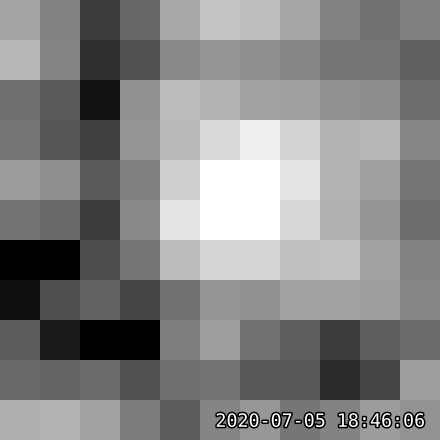

In [6]:
# display the gif
if not os.path.exists(gif):
    print("No gif found. Cannot display gif of time-series.")

Image(gif, embed=True)

<a id="find_tic"></a>
### Find targets within TPF FOV in TESS Input Catalog
We also want to retrieve all objects from the TESS Input Catalog that are within the custom TESS cutout field of view.  We can use **Astroquery** [Catalogs.query_region](https://astroquery.readthedocs.io/en/latest/mast/mast.html#catalog-queries) to do this.  This takes a string input of RA, Dec, and a search radius in degrees, and which catalog to search on.  Since our fov is the total width/height of the cutout, we use ``fov/2.`` to get a radius. 

In [7]:
catalogData = Catalogs.query_region(target, radius=fov/2., catalog="Tic")
print('n_targets', len(catalogData))
print('example rows:\n', catalogData[0:5]['ID', 'ra', 'dec'])

n_targets 66
example rows:
     ID           ra               dec       
--------- ---------------- -----------------
 29831208 66.5825404525073 -67.8064944368234
679837317 66.5771964426473 -67.8089030147979
 29831210 66.5937946490474 -67.8083356715371
 29831207 66.5972344279075 -67.8035677103989
 29831206 66.5589879958632 -67.8033640612713


<a id="plot_tpf_tic"></a>
### Plot static TPF image and overlay TIC catalog
Let's overylay the catalog search results with the custom TESS cutout.  We first need to convert the RA, Dec of all the catalog objects into pixel coordinates on the TESS cutout image.  We can do this using the [Astropy WCS](http://docs.astropy.org/en/stable/wcs/) object, with the ``all_world2pix`` method.  

In [8]:
# get RA and Dec coords of catalog data
tic_ra = catalogData['ra']
tic_dec = catalogData['dec']

# get pixel coordinates of RA and Dec 
coords = wcs.all_world2pix(list(zip(tic_ra, tic_dec)),0)
xc = [c[0] for c in coords]
yc = [c[1] for c in coords]

Let's use matplotlib to plot the first frame in the time-series of the cutout.  We use ``matplotlib.pyplot.imshow``.  Now that we have the catalog object positions in pixel coordinates, we can overlay them as a scatter plot with ``matplotlib.pyplot.scatter``.  We've optionally included a ``use_wcs`` flag to create the plot using the WCS.  See [Matplotlib Plots With WCS](http://docs.astropy.org/en/stable/wcs/#matplotlib-plots-with-correct-wcs-projection) for more details.  We can pass a WCS object as a matplotlib axis projection.  Try setting ``use_wcs = True``.  This will create the plot using the World Coordinates as the x,y axes. 

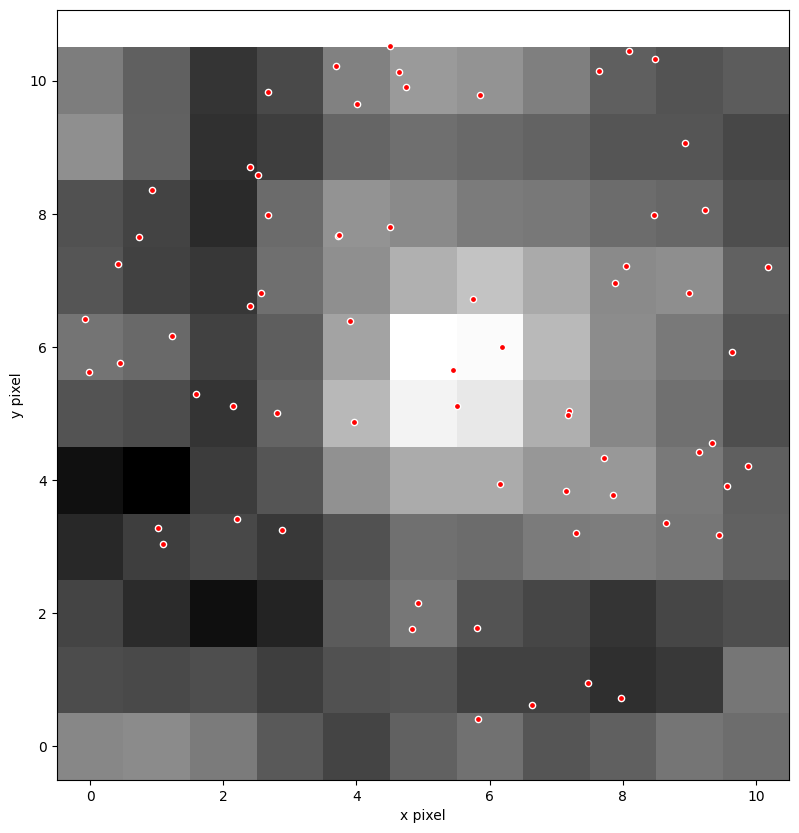

In [9]:
# get first frame of flux from TPF
data = tpf.hdulist['PIXELS'].data["FLUX"][0,:,:]

# use log image normalization
norm = simple_norm(data, 'log')

# plot with wcs or not
use_wcs = False

# plot image and overlay TIC points
ax = plt.subplot(projection=wcs if use_wcs else None)
ax.imshow(data, origin='lower', norm=norm, cmap='gray')
#ax.scatter(tic_ra, tic_dec, transform=ax.get_transform('world'), s=20, facecolor='red', edgecolor='white')
ax.scatter(xc, yc, s=20, facecolor='red', edgecolor='white')


ax.figure.set_size_inches((10,10))

# deal with axes
if use_wcs:
    xax = ax.coords[0]
    yax = ax.coords[1]
    xax.set_ticks(spacing=1.*u.arcmin)
    yax.set_ticks(spacing=0.5 * u.arcmin)
    xax.set_axislabel('Right Ascension')
    yax.set_axislabel('Declination')
else:
    ax.set_xlabel('x pixel')
    ax.set_ylabel('y pixel')

<a id="get_dss"></a>
## Retrieve the DSS image of the region
To overlay the TESSCut image against the DSS image, we need to query the STScI DSS Cutout Image service.  First we define a custom function, ``getdss``, to perform call.  This performs a basic http GET request to the given url and retrieves a DSS image cutout given some input parameters.  

In [10]:
url = "https://archive.stsci.edu/cgi-bin/dss_search"
plateDict = {"red": "2r", 
             "blue": "2b", 
             "ukred": "poss2ukstu_red", 
             "ukblue": "poss2ukstu_blue"}

def getdss(ra, dec, plate="red", height=None, width=None, 
           filename=None, directory=None):

    """Extract DSS image at position and write a FITS file
    
    ra, dec are J2000 coordinates in degrees
    plate can be "red", "blue", "ukred", or "ukblue"
    height and width are in arcmin, default = 7.0.  Image is square if only one is specified.
    filename specifies name for output file (default="dss_{plate}_{ra}_{dec}.fits")
    directory is location for output file (default is current directory)
    
    Returns the name of the file that was written
    """

    # set defaults for height & width
    if height is None:
        if width is not None:
            height = width
        else:
            height = 7.0
            width = 7.0
    elif width is None:
        width = height

    try:
        vplate = plateDict[plate]
    except KeyError:
        raise ValueError("Illegal plate value '{}'\nShould be one of {}".format(
            plate,', '.join(plateDict.keys())))

    # construct filename
    if filename is None:
        filename = "dss_{}_{:.6f}_{:.6f}.fits".format(plate,ra,dec)
    if directory:
        filename = os.path.join(directory, filename)

    params={"r": ra,
            "d": dec,
            "v": vplate,
            "e": "J2000",
            "h": height,
            "w": width,
            "f":"fits",
            "c":"none",
            "s": "yes"}
    r = requests.get(url, params=params)

    # read and format the output
    value = r.content
    if not r.content.startswith(b"SIMPLE  ="):
        raise ValueError("No FITS file returned for {}".format(filename))
    fhout = open(filename, "wb")
    fhout.write(r.content)
    fhout.close()
    return filename

We pass in our target RA and Dec, along with the desired image size in arcminutes, and an optional download path.  

In [11]:
# compute the pixel area in arcmin
arcmin = area.to(u.arcmin).value

# retrieve the DSS file
filename = getdss(ra, dec, height=arcmin, width=arcmin, directory=path)
print('DSS Image:', filename)

DSS Image: /home/runner/work/mast_notebooks/mast_notebooks/notebooks/TESS/interm_tesscut_dss_overlay/dss_red_66.582618_-67.806508.fits


Let's display the DSS image and overlay the TIC catalog objects as a coherence check. We use the same matplotlib plotting methods as before. As before, this uses [WCSAxes](http://docs.astropy.org/en/stable/visualization/wcsaxes/index.html#wcsaxes) from Astropy to create a plot with correct WCS and overlay coordinate objects. This time we create a DSS WCS object and use that when creating the plot. We can also directly pass into a coordinate list of RA, Dec and transform the coordinates into the proper pixels using the DSS WCS.   

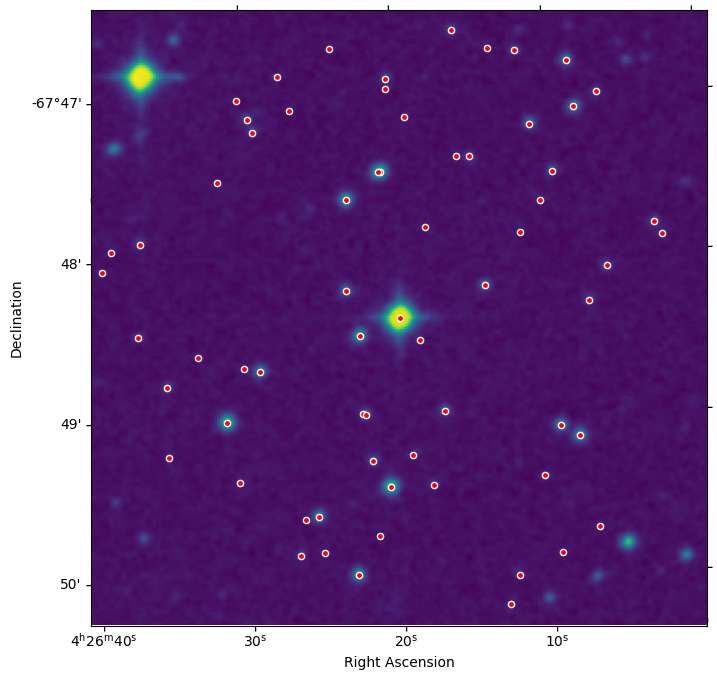

In [12]:
dss = fits.open(filename)

# get the data and WCS for the DSS image
dss_data = dss[0].data
dss_wcs = WCS(dss[0].header)

# display the DSS image and overlay the TIC objects
ax = plt.subplot(projection=dss_wcs)
ax.imshow(dss_data, origin='lower')
ax.scatter(tic_ra, tic_dec, transform=ax.get_transform('world'), s=20, facecolor='red', edgecolor='white')
ax.figure.set_size_inches((8,8))
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

<a id="overlay_images"></a>
## Overlay the TessCut Image
To overlay the TESS Cutout against the DSS, we need to reproject the WCS of the TESS cutout onto the WCS of the DSS image, and the [reproject](https://reproject.readthedocs.io/en/stable/index.html) package.  We use the [reproject_interp](https://reproject.readthedocs.io/en/stable/api/reproject.reproject_interp.html#reproject.reproject_interp) method.  See [here](https://reproject.readthedocs.io/en/stable/celestial.html) for more details. 

``reproject_interp`` takes two basic inputs.  
- input data+WCS we want to project from
- output WCS we want to project onto.  

We want to project our TESS cutout and its WCS into the coordinate frame of the DSS image, using the DSS WCS.  Our input is a tuple of the custom TESS cutout data and wcs, i.e. ``(data, wcs)``.  The desired coordinate frame is the WCS we want to project onto, i.e. ``dss_wcs``.  We also need to provide the shape of the DSS data, with `shape_out`.  Finally we need to provide an interpolation method.  We use a ``nearest-neighbor`` interpolation, which is the lowest order possible.  

``reproject_interp`` will take the input 11x11 pixel TESS cutout data, convert it to world coordinates using the TESS WCS, interpolate it into the shape of the DSS image (229x229) using the DSS WCS, and convert the data into DSS pixel coordinates.  

The final output is the reprojected TESS cutout data (``reproj_tesscut``) and the overlapping footprint of the input data in the output data (``footprint``).  


In [13]:
# reproject the tesscut onto dss
reproj_tesscut, footprint = reproject_interp((data, wcs,), dss_wcs, shape_out=dss_data.shape, order='nearest-neighbor')

Once reprojected, we can properly overly the DSS and TESSCut images.  We can add a slider for the opacity of the overlay using ipywidgets.  First we make a `create_plot` function which accepts all the inputs we need to display the DSS image, and overlay the TESS cutout image and TIC objects.  

In [14]:
# create the function to overlay dss + tesscut + tic catalog
def create_plot(background_img, foreground_img, alpha, norm, wcs, ra, dec):
    ''' create an interactive matplotlib image plot
    
    Parameters:
        background_img (ndarray):
            The background image data to show
        foreground_img (ndarray):
            The foreground image data to overplot. 
        alpha (tuple):
            A tuple of min, max for the interactive slider.  
        norm:
            The image normalization to use for the overlaid image.
        wcs (astropy.wcs.wcs.WCS):
            The WCS of the background image
        ra (list):
            A list of RA coordinate objects
        dec (list):
            A list of Dec coordinate objects
    '''
    # create plot
    ax = plt.subplot(projection=wcs)
    ax.figure.set_size_inches((8,8))

    # show image 1
    ax.imshow(background_img, origin='lower')

    # overlay image 2
    ax.imshow(foreground_img, origin='lower', alpha=alpha, norm=norm, cmap='gray')

    # overlay a list of objects
    ax.scatter(ra, dec, transform=ax.get_transform('world'), s=20, facecolor='red', edgecolor='white')

    # add axis labels
    ax.set_xlabel('Right Ascension')
    ax.set_ylabel('Declination')

Let's do a quick test of our `create_plot` overlay function.

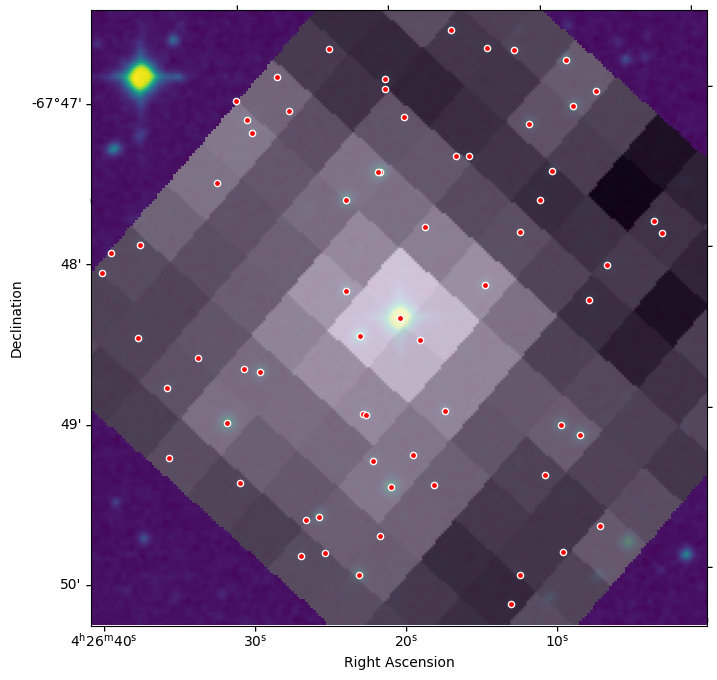

In [15]:
create_plot(background_img=dss_data, foreground_img=reproj_tesscut, 
            alpha=0.75, norm=norm, wcs=dss_wcs, 
            ra=tic_ra, dec=tic_dec)

We can see the "grainy" TESS pixels overlayed on the DSS background. The light from the bright star at the center of the DSS image spreads out over many TESS pixels.

Now let's use ipywidgets to create an interactive slider widget for the alpha/opacity of the TESS cutout image.  We use the [interactive](https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html#interactive) function to produce an interactive widget.  It takes as input the main function we want to make interactive, in our case, `create_plot`.  You also need to pass in all the inputs to your custom function.  

To create a slider for alpha we pass in a tuple of **(min, max)** representing the minimum and maximum slider ranges.  All other inputs to our `create_plot` function should be fixed.  We do not want interaction on these elements.  So we wrap all other inputs in the [fixed](https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html#Fixing-arguments-using-fixed) function from `ipywidgets`.  This tells ipywidgets to use fix those inputs. 

Our input background data is the DSS image data, `dss_data`.  The input image to overlay on top is the reprojected TESS data, `reproj_tesscut`.  We also pass in `norm`, the TESS cutout image normalization from before, as well as DSS wcs (`dss_wcs`), and the list of RA and Dec of the TIC objects, `tic_ra, tic_dec`. 

Try moving the slider back and forth to control the opacity of the TESS cutout image against the DSS image. 

**Note:** this interactive widget does not work in our rendered HTML, and so has been commented out. Un-comment it if you are running this locally.

In [16]:
# # create an interactive ipywidget plot for the opacity of tesscut
# interactive_plot = interactive(create_plot, background_img=fixed(dss_data), foreground_img=fixed(reproj_tesscut), 
#                                alpha=(0.0,1.0), norm=fixed(norm), wcs=fixed(dss_wcs), 
#                                ra=fixed(tic_ra), dec=fixed(tic_dec))
# # display the plot
# output = interactive_plot.children[-1]
# output.layout.height = '500px'
# interactive_plot

<a id="resources"></a>
## Additional Resources
[TESScut API Documentation](https://mast.stsci.edu/tesscut/)<br>
[Astrocut Documentation](https://astrocut.readthedocs.io/en/latest/)<br>
[TESS Homepage](https://archive.stsci.edu/tess)<br>
[TESS Archive Manual](https://outerspace.stsci.edu/display/TESS/TESS+Archive+Manual)

<a id="about_ID"></a>
## About this Notebook
**Author:** Brian Cherinka, STScI Archive Scientist
<br>**Last Updated:** Nov 2023

[Top of Page](#title_ID)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="STScI logo" width="200px"/> 